# Load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path =  '/content/drive/MyDrive/AI/data_6'
data = ['test', 'train', 'train_cleaned']
batch_size = 64

#Pre processing

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transform
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np 
import math
from PIL import Image
import glob

import shutil
import os

from torchvision import datasets
from torchvision.utils import save_image

In [ ]:
out_0 = os.listdir(path + '/' + data[0])
out_0.sort()
out_1 = os.listdir(path + '/' + data[1])
out_1.sort()
out_2 = os.listdir(path + '/' + data[2])
out_2.sort()

print(out_0)
print(out_1)
print(out_2)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
standar_size = (540,258)
import torchvision.transforms.functional as TF
from PIL import Image

test_set = []
for i in out_0:
  a = Image.open(path + '/' + data[0] + '/' + i)
  a = a.resize(standar_size)
  x = TF.to_tensor(a)
  x.unsqueeze_(0)
  test_set.append(x)

train_set = []
for i in out_1:
  a = Image.open(path + '/' + data[1] + '/' + i)
  a = a.resize(standar_size)
  x = TF.to_tensor(a)
  x.unsqueeze_(0)
  train_set.append(x)

train_cleaned_set = []
for i in out_2:
  a = Image.open(path + '/' + data[2] + '/' + i)
  a = a.resize(standar_size)
  x = TF.to_tensor(a)
  x.unsqueeze_(0)
  train_cleaned_set.append(x)

In [ ]:
#Loaders
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
train_clean_loader = torch.utils.data.DataLoader(dataset=train_cleaned_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)


# Autoencoder CNN

In [ ]:
pool = nn.MaxPool2d(2, stride=2, return_indices=True)
unpool = nn.MaxUnpool2d(2, stride=2)

def flatten(t):
    t = t.reshape(1, -1)
    t = t.squeeze()
    return t

class Encoder(nn.Module):
  def __init__(self):
    super(Encoder,self).__init__()
    self.f1 = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
    )
    self.f2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
    )
    self.f3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
    )
    self.f4 = nn.Sequential(
            nn.Linear(1105920, 20)
    )

  def forward(self, image):
    out = self.f1(image)
    out, indices1 = pool(out)
    out = self.f2(out)
    out, indices2 = pool(out)
    out = self.f3(out)
    z = flatten(out)
    z = self.f4(z)
    return z, indices1,  indices2

class Decoder(nn.Module):
  def __init__(self):
    super(Decoder,self).__init__()

    self.f0 = nn.Sequential(
            nn.Linear(20, 1105920)
    )

    self.f1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
    )
    self.f2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=(4,3), stride=1, padding=1),
            nn.ReLU()
    )
    self.f3 = nn.Sequential(
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
    )

  def forward(self, z):
    z, indices1, indices2= z
    z = self.f0(z)
    z = z.reshape(128, 64, 135).unsqueeze(dim = 0)
    out = self.f1(z)
    out = unpool(out, indices2)
    out = self.f2(out)
    out = unpool(out, indices1)
    out = torch.tanh(self.f3(out))
    return out

class Process(nn.Module):
  def __init__(self):
    super(Process,self).__init__()
    self.f1 = nn.Sequential(
        nn.Conv2d(1, 3, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
    )
    self.f2 = nn.Sequential(
            nn.Conv2d(3, 5, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
    )
    self.f3 = nn.Sequential(
            nn.Conv2d(5, 3, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
    )
    self.f4 = nn.Sequential(
            nn.Conv2d(3, 1, kernel_size=3, stride=1, padding=1)
    )

  def forward(self, image):
    out = self.f1(image)
    out = self.f2(out)
    out = self.f3(out)
    z = torch.tanh(self.f4(out))
    return z

class Autoncoder(nn.Module):
  def __init__(self):
    super(Autoncoder,self).__init__()
    self.encoder = Encoder()
    self.Decoder = Decoder()
    self.Process = Process()
    self.Process2 = Process()
  def forward(self, image):
    z = self.encoder(image)
    out = self.Decoder(z)
    out = self.Process(out)
    out = self.Process2(out)
    return out
  def reiniciar(self):
    super(Autoncoder,self).__init__()
    self.encoder = Encoder()
    self.Decoder = Decoder()
    self.Process = Process()
    self.Process2 = Process()

Notes:
* All the train set contains the same text and all the test set contains the same text too, but is different from train set
* The loss should be at leas 0.025 to archive aceptable results.
* The loss can get stuck between 0.06 and 0.05 which implies that the image is all white or mostly white without defined letters.
* If the loss get stuck between 0.06 and 0.05, it is mostly likely that the learning rate is incorrect
* A simple CNN can archive good results but as our goal is to reduce dimentionality we use a CNN autoencoder  

## Functions

In [ ]:
def Show(out, title = ''):
  print(title)
  out = out.permute(1,0,2,3)
  grilla = torchvision.utils.make_grid(out,10,5)
  plt.imshow(transforms.ToPILImage()(grilla), 'jet')
  plt.show()

def Show_Weight(out):
  grilla = torchvision.utils.make_grid(out)
  plt.imshow(transform.ToPILImage()(grilla), 'jet')
  plt.show()

Upload a image and put it in the autoencoder

In [ ]:
def img_autoencoder(model, path_i):
  autoencoder = model.to(device)
  a = Image.open(path_i)
  a = a.resize(standar_size)
  a = a.convert('L')
  img = TF.to_tensor(a)
  img.unsqueeze_(0)
  img = img.to(device)
  Show_Weight(img)
  img_recon = autoencoder(img)
  img_recon = img_recon.to(device)
  Show_Weight(img_recon)
  return img_recon

In [ ]:
from sklearn.utils import shuffle

def train(model, train_s, train_cleaned_s, Epochs, loss_fn):
    train_loss_avg = []
    for epoch in range(Epochs):
      train_loss_avg.append(0)
      num_batches = 0
      
      #for img in train_s:
      train_s, train_cleaned_s = shuffle(train_s, train_cleaned_s)
      for i in range(batch_size):
          img = train_s[i]
          #img = img.view(img.size(0),-1)
          img = img.to(device)
          img_recon = model(img)
          #img_clean = train_cleaned_s[i].view(train_cleaned_s[i].size(0),-1).to(device)
          img_clean = train_cleaned_s[i].to(device)
          loss = loss_fn(img_recon, img_clean)
          
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          train_loss_avg[-1] += loss.item()
          num_batches += 1
      
      train_loss_avg[-1] /= num_batches
      print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, Epochs, train_loss_avg[-1]))
      if loss < 0.005:
        break    
    return train_loss_avg

k-fold

In [ ]:
def Kfold_t(model, train_s, train_cleaned_s, Epochs, loss_fn, optimizer, fold=10):
  kfold = KFold(n_splits=fold, shuffle=False)
  loss_array = []
  for fold, (train_ids, test_ids) in enumerate(kfold.split(range(len(train_s)))):
    model.reiniciar()
    model.to(device)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=1e-5)

    num_batches_train = 0
    train_loss_avg = []
    for epoch in range(Epochs):
      train_loss_avg.append(0)
      for i in train_ids:
        img = train_s[i]
        img = img.to(device)
        img_recon = model(img)
        img_clean = train_cleaned_s[i].to(device)
        loss = loss_fn(img_recon, img_clean)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_avg[-1] += loss.item()
        num_batches_train += 1
      train_loss_avg[-1] /= num_batches_train
      print('Fold: ', fold, 'Epoch: [',epoch+1, '/',Epochs,'] Loss:', train_loss_avg[-1])
    
    img_test = model(test_set[0].to(device))
    Show_Weight(img_test)

    test_loss_avg = []
    test_loss_avg.append(0)
    num_batches = 0
    for i in test_ids:
      img = train_s[i]
      img = img.to(device)
      img_recon = model(img)
      img_clean = train_cleaned_s[i].to(device)
      loss = loss_fn(img_recon, img_clean)
      test_loss_avg[-1] += loss.item()
      num_batches += 1
      print('Test: [',i+1, '/',len(test_ids),'] Loss:', loss.item())
    # if loss < 0.005:
    #   break
    test_loss_avg[-1] /= num_batches
    loss_array.append(test_loss_avg[-1])
    print('         Fold: ', fold, 'Test avg Loss:', loss_array[-1])
    print(len(test_loss_avg))
  return loss_array


###Experimentation

Fold:  0 Epoch: [ 1 / 40 ] Loss: 0.7205267367155656
Fold:  0 Epoch: [ 2 / 40 ] Loss: 0.3511298988176429
Fold:  0 Epoch: [ 3 / 40 ] Loss: 0.22814594766368038
Fold:  0 Epoch: [ 4 / 40 ] Loss: 0.16676138924515765
Fold:  0 Epoch: [ 5 / 40 ] Loss: 0.13001481170239657
Fold:  0 Epoch: [ 6 / 40 ] Loss: 0.10558594085168148
Fold:  0 Epoch: [ 7 / 40 ] Loss: 0.08819469420806221
Fold:  0 Epoch: [ 8 / 40 ] Loss: 0.07520100727029469
Fold:  0 Epoch: [ 9 / 40 ] Loss: 0.065138180071605
Fold:  0 Epoch: [ 10 / 40 ] Loss: 0.05712619154349617
Fold:  0 Epoch: [ 11 / 40 ] Loss: 0.05060501951473975
Fold:  0 Epoch: [ 12 / 40 ] Loss: 0.04520112392695054
Fold:  0 Epoch: [ 13 / 40 ] Loss: 0.02743409450935281
Fold:  0 Epoch: [ 14 / 40 ] Loss: 0.0046594634328199465
Fold:  0 Epoch: [ 15 / 40 ] Loss: 0.00391656463128933
Fold:  0 Epoch: [ 16 / 40 ] Loss: 0.0032798562765769335
Fold:  0 Epoch: [ 17 / 40 ] Loss: 0.0028069264157806213
Fold:  0 Epoch: [ 18 / 40 ] Loss: 0.0024452712998729973
Fold:  0 Epoch: [ 19 / 40 ] Loss:

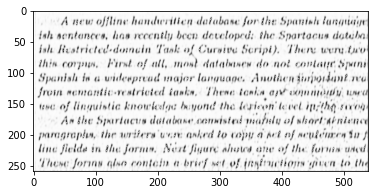

Test: [ 1 / 29 ] Loss: 0.019870735704898834
Test: [ 2 / 29 ] Loss: 0.020088033750653267
Test: [ 3 / 29 ] Loss: 0.019734708592295647
Test: [ 4 / 29 ] Loss: 0.019797926768660545
Test: [ 5 / 29 ] Loss: 0.020441574975848198
Test: [ 6 / 29 ] Loss: 0.020578661933541298
Test: [ 7 / 29 ] Loss: 0.01728012226521969
Test: [ 8 / 29 ] Loss: 0.02134036459028721
Test: [ 9 / 29 ] Loss: 0.022027654573321342
Test: [ 10 / 29 ] Loss: 0.021432535722851753
Test: [ 11 / 29 ] Loss: 0.022028204053640366
Test: [ 12 / 29 ] Loss: 0.02133987843990326
Test: [ 13 / 29 ] Loss: 0.02172216586768627
Test: [ 14 / 29 ] Loss: 0.022784152999520302
Test: [ 15 / 29 ] Loss: 0.016203483566641808
Test: [ 16 / 29 ] Loss: 0.023332392796874046
Test: [ 17 / 29 ] Loss: 0.01881875842809677
Test: [ 18 / 29 ] Loss: 0.02006547898054123
Test: [ 19 / 29 ] Loss: 0.01861552521586418
Test: [ 20 / 29 ] Loss: 0.019529731944203377
Test: [ 21 / 29 ] Loss: 0.018847545608878136
Test: [ 22 / 29 ] Loss: 0.019455958157777786
Test: [ 23 / 29 ] Loss: 0.

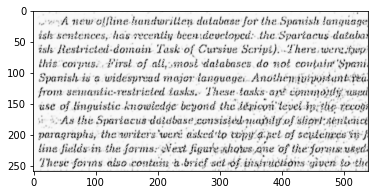

Test: [ 30 / 29 ] Loss: 0.014682408422231674
Test: [ 31 / 29 ] Loss: 0.013312864117324352
Test: [ 32 / 29 ] Loss: 0.013236097060143948
Test: [ 33 / 29 ] Loss: 0.014005139470100403
Test: [ 34 / 29 ] Loss: 0.012956762686371803
Test: [ 35 / 29 ] Loss: 0.013145320117473602
Test: [ 36 / 29 ] Loss: 0.01223556324839592
Test: [ 37 / 29 ] Loss: 0.014042271301150322
Test: [ 38 / 29 ] Loss: 0.012342337518930435
Test: [ 39 / 29 ] Loss: 0.013528911396861076
Test: [ 40 / 29 ] Loss: 0.012435555458068848
Test: [ 41 / 29 ] Loss: 0.012592293322086334
Test: [ 42 / 29 ] Loss: 0.01266412902623415
Test: [ 43 / 29 ] Loss: 0.013141288422048092
Test: [ 44 / 29 ] Loss: 0.013642149046063423
Test: [ 45 / 29 ] Loss: 0.012368184514343739
Test: [ 46 / 29 ] Loss: 0.01264769397675991
Test: [ 47 / 29 ] Loss: 0.013896669261157513
Test: [ 48 / 29 ] Loss: 0.012790649197995663
Test: [ 49 / 29 ] Loss: 0.012681097723543644
Test: [ 50 / 29 ] Loss: 0.01290119532495737
Test: [ 51 / 29 ] Loss: 0.012779822573065758
Test: [ 52 / 2

KeyboardInterrupt: ignored

In [ ]:
from sklearn.model_selection import KFold
learning_rate = 0.0001
autoencoder = Autoncoder()
autoencoder.to(device)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)
autoencoder.train()
loss_values = Kfold_t(autoencoder, train_set, train_cleaned_set, 40, loss, optimizer, 5)

# se puede parar la ejecucio cuando ya el lost cambia muy poco ocila entre valores

In [ ]:
fig = plt.figure()
plt.plot(loss_values)
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.show()

1
torch.Size([1, 1, 258, 540])
torch.Size([1, 1, 258, 540])


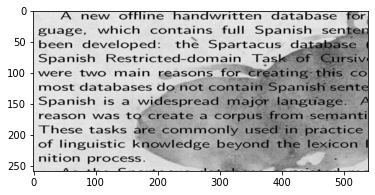

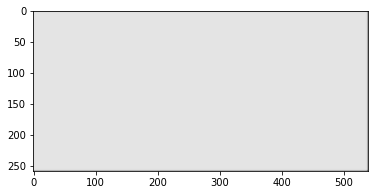

In [ ]:
#autoencoder = Autoncoder()
autoencoder = autoencoder.to(device)
img = test_set[5]
print(img.size(1))
#img = img.reshape(1, -1)
img = img.to(device)
print(img.shape)
img_recon = autoencoder(img)
print(img_recon.shape)
img_recon = img_recon
#img_recon = img_recon.reshape(258, -1)
Show_Weight(img)
Show_Weight(img_recon)

In [ ]:
learning_rate = 0.0001
autoencoder_p = Autoncoder()
autoencoder_p.to(device)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(params=autoencoder_p.parameters(), lr=learning_rate, weight_decay=1e-5)
autoencoder_p.train()
loss_values = train(autoencoder_p, train_set, train_cleaned_set, 60, loss)


Epoch [1 / 60] average reconstruction error: 0.555662
Epoch [2 / 60] average reconstruction error: 0.449218
Epoch [3 / 60] average reconstruction error: 0.327970
Epoch [4 / 60] average reconstruction error: 0.196220
Epoch [5 / 60] average reconstruction error: 0.113502
Epoch [6 / 60] average reconstruction error: 0.077521
Epoch [7 / 60] average reconstruction error: 0.066940
Epoch [8 / 60] average reconstruction error: 0.059505
Epoch [9 / 60] average reconstruction error: 0.051519
Epoch [10 / 60] average reconstruction error: 0.048692
Epoch [11 / 60] average reconstruction error: 0.044404
Epoch [12 / 60] average reconstruction error: 0.039172
Epoch [13 / 60] average reconstruction error: 0.037244
Epoch [14 / 60] average reconstruction error: 0.033733
Epoch [15 / 60] average reconstruction error: 0.032162
Epoch [16 / 60] average reconstruction error: 0.029499
Epoch [17 / 60] average reconstruction error: 0.027678
Epoch [18 / 60] average reconstruction error: 0.025299
Epoch [19 / 60] ave

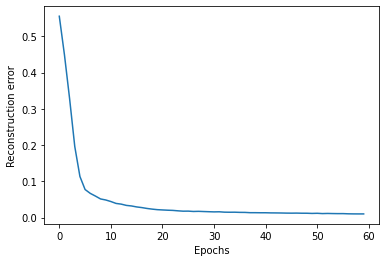

In [ ]:
fig = plt.figure()
plt.plot(loss_values)
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.show()

Experimentation with no text photos

In [ ]:
out_3 = os.listdir(path + '/' + 'exotic')
out_3.sort()

print(out_3)

['exotic_1.png', 'exotic_2.png', 'patricio.png']


In [ ]:
exotic_set = []
for i in out_3:
  a = Image.open(path + '/' + data[3] + '/' + i)
  a = a.resize(standar_size)
  a = a.convert('L')
  x = TF.to_tensor(a)
  x.unsqueeze_(0)
  exotic_set.append(x)

torch.Size([1, 1, 258, 540])


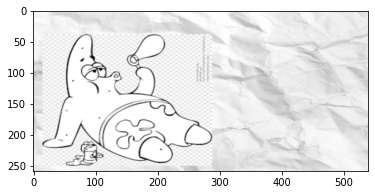

In [ ]:
img = exotic_set[2]
print(img.shape)
Show_Weight(img)

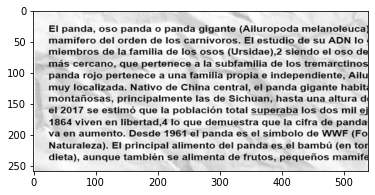

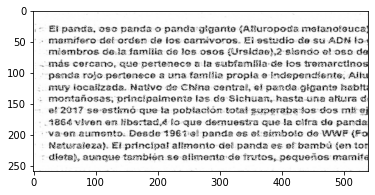

In [ ]:
autoencoder = autoencoder.to(device)

img = exotic_set[0]
img = img.to(device)
img_recon = autoencoder(img)

Show_Weight(img)
Show_Weight(img_recon)

torch.Size([128, 64, 12])


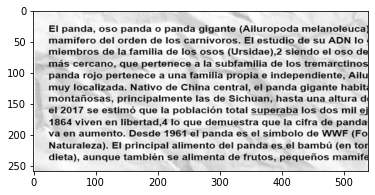

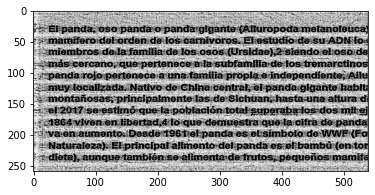

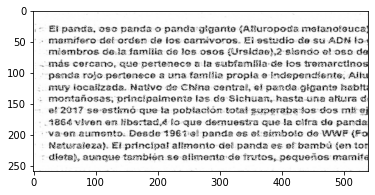

In [ ]:
autoencoder = autoencoder.to(device)
img = exotic_set[0]
img = img.to(device)

img_recon, indices1, indices2 = autoencoder.encoder(img)

for i in img_recon:
  print(i.shape)

img_recon = img_recon, indices1, indices2
img_recon= autoencoder.Decoder(img_recon)
Show_Weight(img)
Show_Weight(img_recon)

img_recon = autoencoder.Process(img_recon)
Show_Weight(img_recon)